In [1]:
## > LIBRARIES
import os
import re
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir('C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/prog/functions/')

from ncaa19 import *

sns.set()

## > DATA
path_datasets = 'C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/datasets/'
path_elab = 'C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/elaborazioni/'

df_in = pd.read_csv(path_datasets + '03Py_NCAA_dataset_con_indicatori.csv', sep = "|")

In [2]:
df_in.head()

,Season,DayNum,TeamID,TeamID_opp,Score_left,Score_right,win_dummy,delta,NumOT,delta_poss_m,...,delta_w_pct,delta_w_pct_last30D,delta_w_pct_vs_topseeds,delta_c_N_season,delta_c_N_champ_W,delta_c_W_PCT_allT,delta_c_W_PCT_vs_topseeds_allT,delta_MOR,delta_POM,delta_SAG
0,2015,134,1214,1264,74,64,1,10,0,0.708333,...,-0.108902,-0.111111,0.000000,2.0,0.0,-0.096119,0.250000,141.0,104.0,107.0
1,2015,134,1140,1279,90,94,0,-4,0,3.496094,...,0.093750,0.430556,-0.196970,0.0,0.0,0.124825,0.022275,-22.0,-13.0,-15.0
2,2015,135,1129,1173,55,56,0,-1,0,-1.108333,...,-0.015640,0.077778,-0.066667,1.0,0.0,-0.053472,-0.083146,-14.0,-1.0,-3.0
3,2015,135,1316,1352,77,81,0,-4,0,0.187488,...,0.069404,0.111111,0.333333,1.0,0.0,-0.161089,-0.301587,-24.0,-46.0,-40.0
4,2015,136,1112,1411,93,72,1,21,0,1.188971,...,0.264706,0.000000,0.857143,-2.0,0.0,0.141711,0.359554,-265.0,-205.0,-200.0


In [3]:
def best_quantile(x, start = 5):
    
    bins = np.nanpercentile(x, np.arange(0, 100, start))
    
    # check duplicates
    check_dup = len(np.unique(bins)) != len(bins)
    
    while check_dup:
        start_update = start*2
        bins = np.nanpercentile(x, np.arange(0, 100, start_update))
        check_dup = len(np.unique(bins)) != len(bins)
        
        start = start_update
        
    return(bins)

def aggr_freq_td(df):
    d = {}
    d['N'] = df['win_dummy'].count()
    d['Nwin'] = df['win_dummy'].sum()
    d['tw'] = d['Nwin'] / d['N']
    
    return pd.Series(d)

## > Isotonic Regression

from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.utils import check_random_state

ir = IsotonicRegression(increasing="auto")

regressors = ['delta_poss_m', 'delta_opp_poss_m',
              'delta_ass_ratio', 'delta_tov_ratio', 
              'delta_reb_rate',
              'delta_opp_true_fg_pct',
              'delta_off_rating_m', 'delta_def_rating_m',
              'delta_net_rating_m', 'delta_pace_m', 'delta_off_rating_m_last30D',
              'delta_def_rating_m_last30D', 'delta_net_rating_m_last30D',
              'delta_off_rating_m_vs_topseeds', 'delta_def_rating_m_vs_topseeds',
              'delta_net_rating_m_vs_topseeds', 
              'delta_w_pct', 'delta_w_pct_last30D',
              'delta_w_pct_vs_topseeds', 'delta_c_N_season',
              'delta_c_W_PCT_allT', 'delta_c_W_PCT_vs_topseeds_allT',
              'delta_MOR', 'delta_POM', 'delta_SAG']


for var_t in regressors:
    bins = best_quantile(df_in[var_t], 2.5)
    
    labels = np.arange(1, len(bins), 1)
    
    df_in[var_t + '_binned'] = pd.cut(df_in[var_t], bins=bins, labels=labels)
    
    prova_gr = df_in.groupby([var_t + '_binned']).apply(aggr_freq_td).reset_index()
    
    prova_gr = prova_gr.rename(columns={var_t + '_binned':'class'})
    
    prova_gr['var'] = var_t
    
    prova_gr['tw_hat'] = ir.fit_transform(prova_gr['class'], prova_gr['tw'])
    
    if var_t == 'delta_poss_m':
        aggr_pre_pav = prova_gr
    else:
        aggr_pre_pav = pd.concat([aggr_pre_pav, prova_gr])
    

C:\Users\cg08900\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
C:\Users\cg08900\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
C:\Users\cg08900\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
C:\Users\cg08900\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence 

C:\Users\cg08900\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\cg08900\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]), <a list of 39 Text xticklabel objects>)

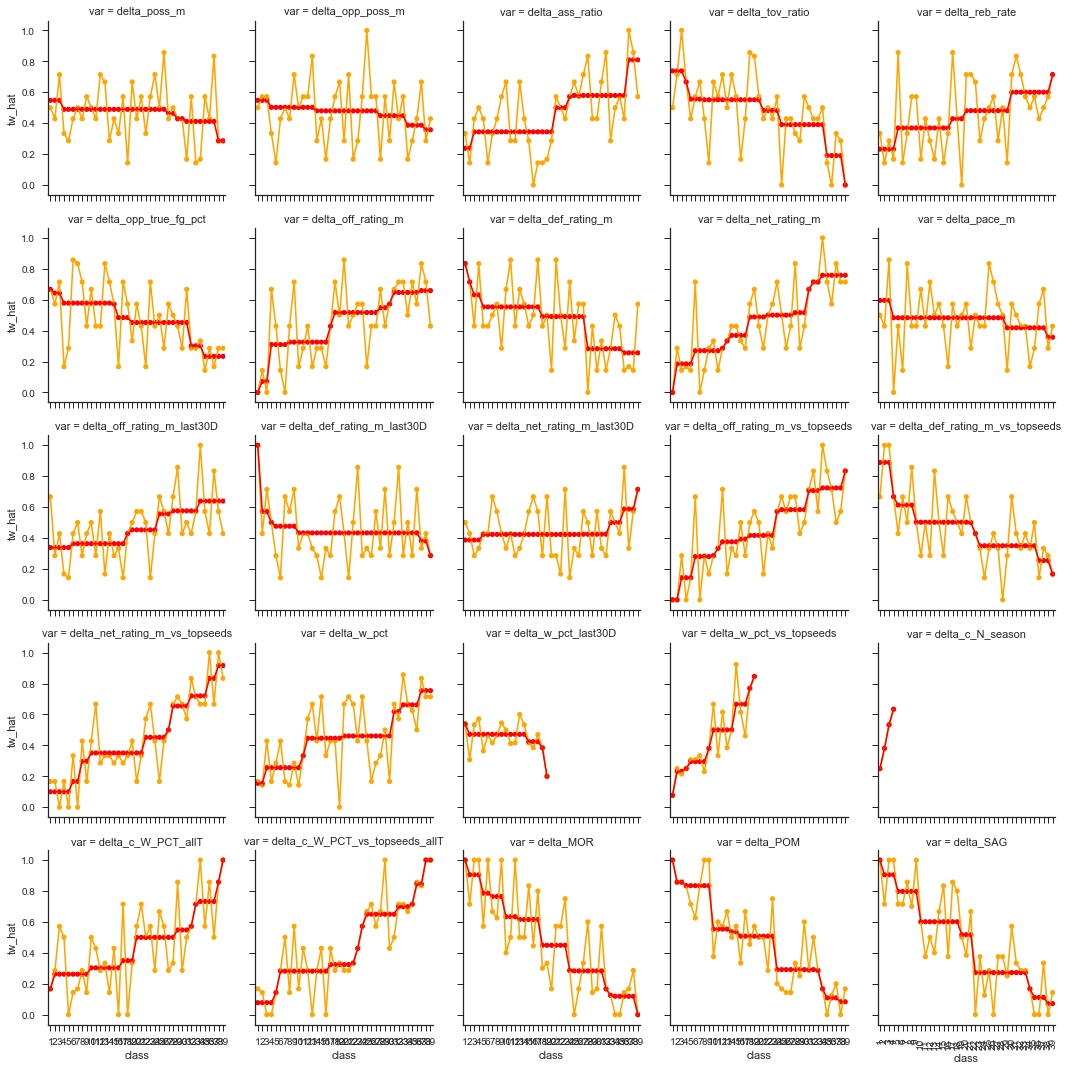

In [4]:
sns.set(style="ticks", color_codes=True)
g = sns.FacetGrid(aggr_pre_pav, col="var", col_wrap=5)
g.map(sns.pointplot, "class", "tw", color='orange', scale=.5)
g.map(sns.pointplot, "class", "tw_hat", color='red', scale=.5)
plt.xticks(rotation=90)

In [34]:
aggr_pre_pav.to_csv(path_datasets + '05Py_NCAA_test_pav.csv', sep='|',
                      index=False)